## Fourier Neural Operator

Add some description

In [1]:
# external imports
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

# continuity imports
from continuity.trainer import Trainer
from continuity.data import OperatorDataset
from continuity.operators.fourier_neural_operator import FourierLayer

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Input function
u = lambda chi: chi*torch.cos(chi)
u = lambda chi: torch.exp(-chi**2)*10

# Target function
v = lambda chi: torch.exp(-chi**2)*10
v = lambda chi: chi
v = lambda chi: torch.exp(-chi**2)*20 * (-chi)

# Domain parameters
L = torch.pi * 2
xi = torch.linspace(-L, L, 1000)  # from the same domain as y and x to plot "continuous" representations of u and v

num_sensors = 32
num_evaluations = 32
x = torch.linspace(-L, L, num_sensors).to(device)
y = torch.linspace(-L, L, num_evaluations).to(device)

# This dataset contains only a single sample (first dimension of all tensors)
n_observations = 1
u_dim = x_dim = y_dim = v_dim = 1
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)
data_loader = DataLoader(dataset)

In [4]:
# Single FNO layer
model = FourierLayer(dataset.shapes)

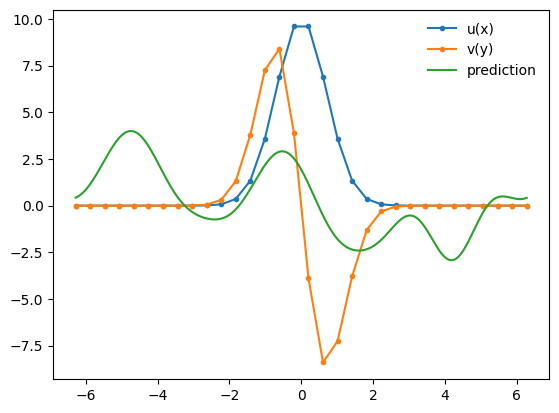

In [5]:
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)
v_pred = model(x_i, u_plot, y_i).squeeze()

plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [8]:
trainer.fit(data_loader, 10000)

Model parameters: 17
Epoch 10000:  loss/train = 8.8681e-09  (0.000224 s/epoch)


In [10]:
# compute prediction adn reshape
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)
v_pred = model(x_i, u_plot, y_i).squeeze()

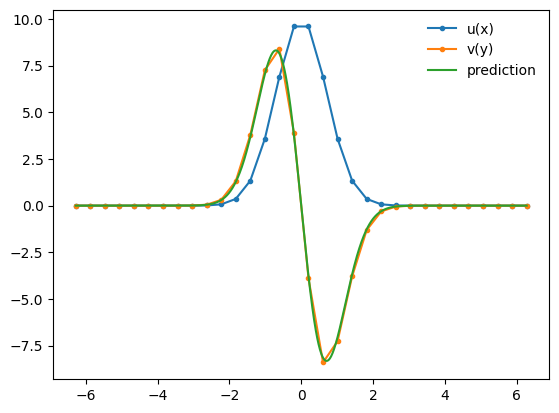

In [11]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

In [12]:
class FNO_network(torch.nn.Module):

    def __init__(self, shapes, num_layer, num_frequencies=None) -> None:
        super().__init__()

        self.first_layer = FourierLayer(shapes, num_frequencies)

        self.layers = torch.nn.ModuleList([
            FourierLayer(shapes, num_frequencies) for _ in range(num_layer)
        ])

        self.last_layer = FourierLayer(shapes, num_frequencies)

    def forward(self, x, u, y):

        u = self.first_layer(x, u, y)
        u = torch.nn.Tanh()(u)

        for layer in self.layers:
            u = layer(x, u, y)
            u = torch.nn.Tanh()(u)

        u = self.last_layer(x, u, y)

        return u

In [13]:
model = FNO_network(dataset.shapes, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)
trainer.fit(data_loader, 10000)

Model parameters: 68
Epoch 10000:  loss/train = 1.8347e-10  (0.000595 s/epoch)


In [14]:
u_plot = u(y_plot)
v_pred = model(x_i, u_plot, y_i).squeeze()

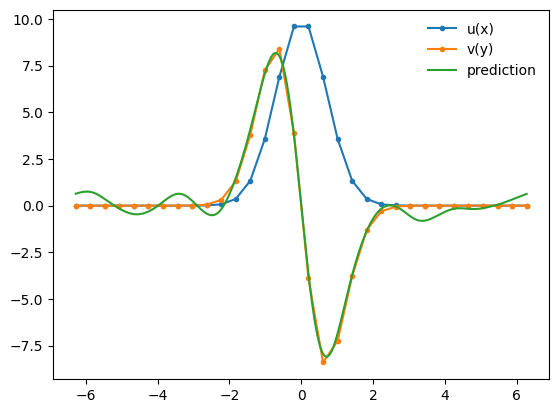

In [16]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

Text(0.5, 0, 'Img(v-fourier)')

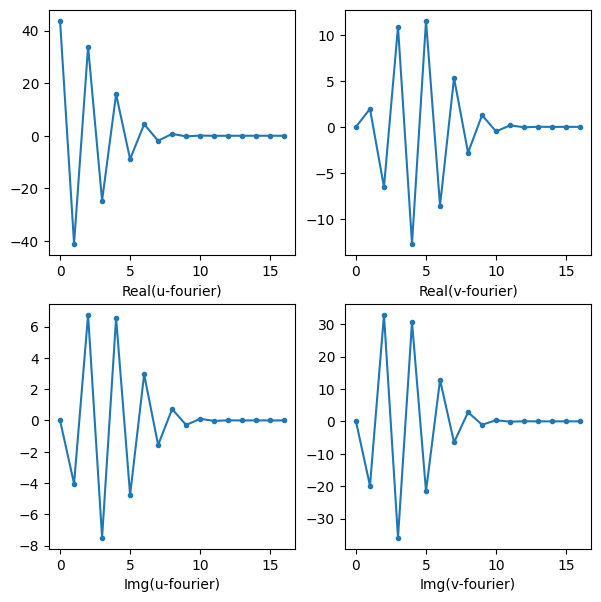

In [17]:
# Fourier transform of input and target function
u_fourier = torch.fft.rfft(u_i, dim=1)
v_fourier = torch.fft.rfft(v_i, dim=1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[7, 7])

frequencies = range(0, len(u_fourier.squeeze()), 1)
ax1.plot(frequencies, u_fourier.squeeze().real, marker=".", label="u(x)")
ax1.set_xlabel("Real(u-fourier)")

ax3.plot(frequencies, u_fourier.squeeze().imag, marker=".", label="u(x)")
ax3.set_xlabel("Img(u-fourier)")

ax2.plot(frequencies, v_fourier.squeeze().real, marker=".", label="v(x)")
ax2.set_xlabel("Real(v-fourier)")

ax4.plot(frequencies, v_fourier.squeeze().imag, marker=".", label="v(x)")
ax4.set_xlabel("Img(v-fourier)")

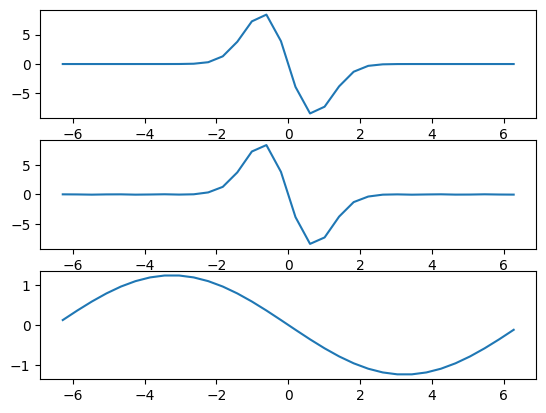

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3)

u_back1 = torch.fft.irfft(v_fourier[:, :, :], dim=1, n=u_i.shape[1])
u_back2 = torch.fft.irfft(v_fourier[:, :10, :], dim=1, n=u_i.shape[1])
u_back3 = torch.fft.irfft(v_fourier[:, :2, :], dim=1, n=u_i.shape[1])

ax1.plot(x_i.flatten(), u_back1.squeeze())
ax2.plot(x_i.flatten(), u_back2.squeeze())
ax3.plot(x_i.flatten(), u_back3.squeeze())

## 2D data set

In [20]:
def multivariate_normal_2d(input_tensor: torch.Tensor, loc: float = 0., scale: float = 1.) -> torch.Tensor:
    """ Multivariate normal 2 dimensional distribution.

    Args:
        input_tensor: input with shape = (num_evaluations, 2)
        loc: Mean of normal dist
        scale: standard deviation of normal dist
    Returns:
        Tensor with shape = (num_evaluations)
    """

    distribution = MultivariateNormal(torch.ones(2) * loc, scale * torch.eye(2))
    value = torch.exp(distribution.log_prob(input_tensor))
    return value

def linear_flat_function(input_tensor: torch.Tensor) -> torch.Tensor:

    return input_tensor[:, 1] * input_tensor[:, 0] / 20

In [21]:

# define grid and flatten
x = torch.linspace(-3, 3, 64)
y = torch.linspace(-3, 3, 64)
xx, yy = torch.meshgrid(x, y)
input_tensor = torch.stack([xx.flatten(), yy.flatten()], axis=1)

# evaluate on grid
u = multivariate_normal_2d(input_tensor)
v = linear_flat_function(input_tensor)

# reshape into grid
u_reshaped = u.reshape(64, 64)
v_reshaped = v.reshape(64, 64)

/Users/michelluchmann/Projects/Continuity/continuity/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Input function v(x)')

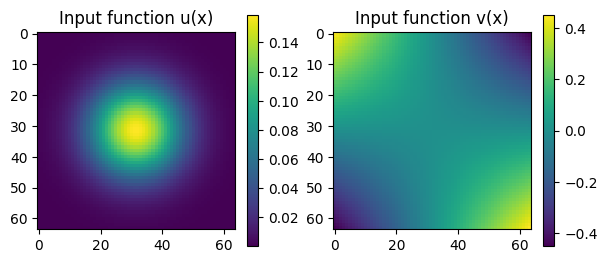

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 3])

img = ax1.imshow(u_reshaped)
fig.colorbar(img)
ax1.set_title("Input function u(x)")

img = ax2.imshow(v_reshaped)
fig.colorbar(img)
ax2.set_title("Input function v(x)")

In [23]:
x_reshaped = torch.stack([xx.flatten(), yy.flatten()], axis=-1).unsqueeze(0)
u_reshaped = u.reshape(1, -1, 1)
v_reshaped = v.reshape(1, -1, 1)

x_reshaped.shape, u_reshaped.shape, v_reshaped.shape

(torch.Size([1, 4096, 2]), torch.Size([1, 4096, 1]), torch.Size([1, 4096, 1]))

In [24]:
dataset_2d = OperatorDataset(
    x_reshaped,
    u_reshaped,
    x_reshaped,
    v_reshaped,
)

shapes = dataset_2d.shapes
data_loader_2d = DataLoader(dataset_2d)

In [25]:
model = FourierLayer(shapes=shapes)

In [26]:
x_i, u_i, y_i, v_i = dataset_2d[:]
v_pred_before = model(x_i, u_i, y_i)

batch_idx = 0
u_i_reshaped = u_i[batch_idx].reshape(64, 64)
v_i_reshaped = v_i[batch_idx].reshape(64, 64)
v_pred_reshaped = v_pred_before[batch_idx].reshape(64, 64)

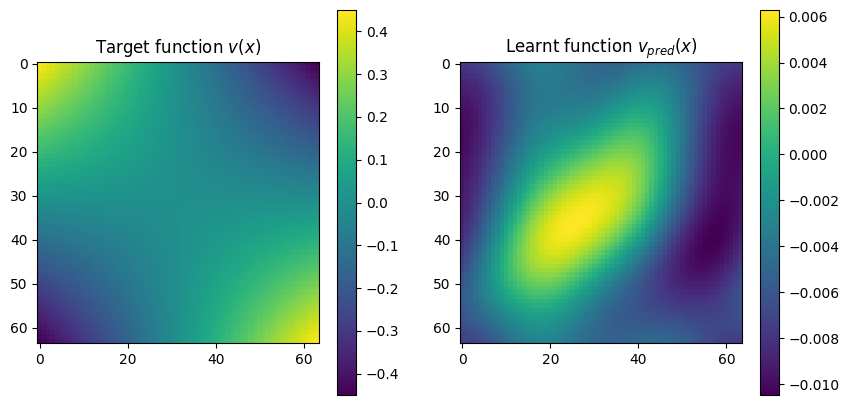

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

img = ax1.imshow(v_i_reshaped.detach())
ax1.set_title(r'Target function $v(x)$')
fig.colorbar(img)

img2 = ax2.imshow(v_pred_reshaped.detach())
ax2.set_title(r'Learnt function $v_{pred}(x)$')
fig.colorbar(img2)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [29]:
trainer.fit(data_loader_2d, 100000)

Model parameters: 1089
Epoch 100000:  loss/train = 1.5512e-02  (0.000262 s/epoch)


In [30]:
# evaluate prediction
v_pred = model(x_i, u_i, y_i)
v_pred_reshaped = v_pred[batch_idx].reshape(64, 64)

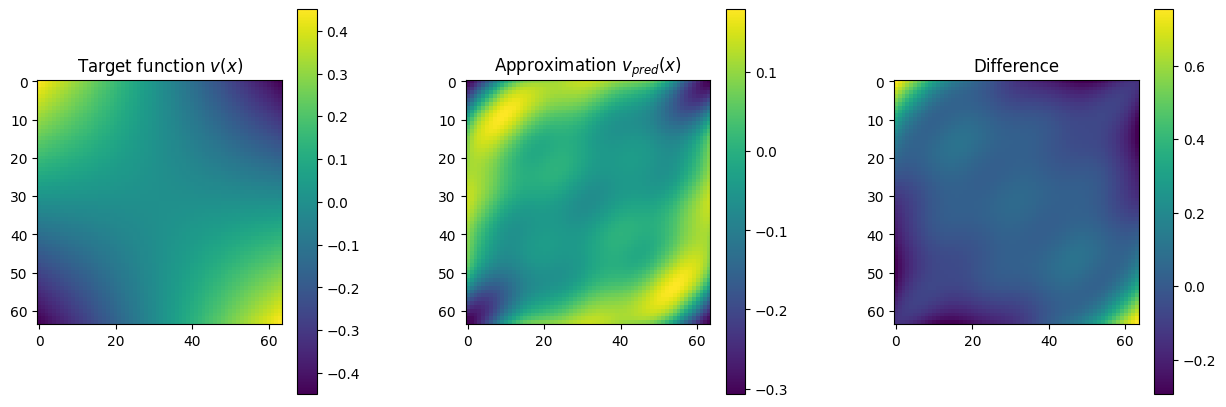

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5], )

img = ax1.imshow(v_i_reshaped.detach())
fig.colorbar(img)
ax1.set_title(r"Target function $v(x)$")

img2 = ax2.imshow(v_pred_reshaped.detach())
fig.colorbar(img2)
ax2.set_title(r"Approximation $v_{pred}(x)$")

img3 = ax3.imshow(v_i_reshaped.detach() - v_pred_reshaped.detach())
fig.colorbar(img3)
ax3.set_title("Difference")

fig.subplots_adjust(wspace=0.4)

In [32]:
model = FNO_network(dataset_2d.shapes, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, device=device, optimizer=optimizer)
trainer.fit(data_loader_2d, 30000)

Model parameters: 6534
Epoch 30000:  loss/train = 1.1958e-02  (0.00166 s/epoch)


In [35]:
# evaluate prediction
v_pred = model(x_i, u_i, y_i)
v_pred_reshaped = v_pred[batch_idx].reshape(64, 64)

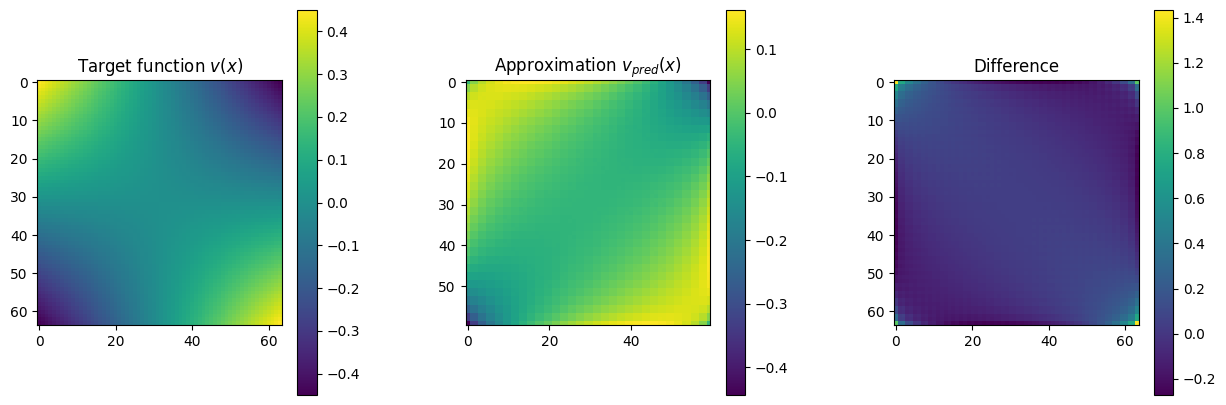

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5], )

img = ax1.imshow(v_i_reshaped.detach())
fig.colorbar(img)
ax1.set_title(r"Target function $v(x)$")

img2 = ax2.imshow(v_pred_reshaped.detach()[2:-2, 2:-2])
fig.colorbar(img2)
ax2.set_title(r"Approximation $v_{pred}(x)$")

img3 = ax3.imshow(v_i_reshaped.detach() - v_pred_reshaped.detach())
fig.colorbar(img3)
ax3.set_title("Difference")

fig.subplots_adjust(wspace=0.4)